inpu 1 if use (Cao,2011) version and input 2 if use (Leong, 2012) version: 
1


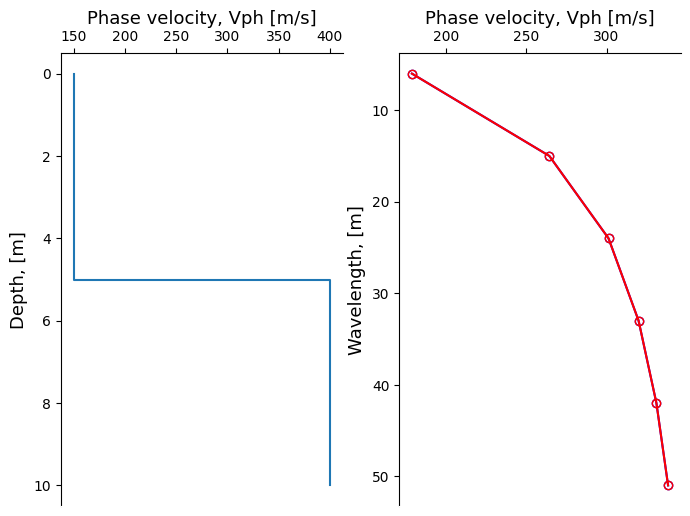

In [6]:
import numpy as np
from numpy.lib.nanfunctions import nanmedian
import sympy as sp
from sympy.core.symbol import disambiguate
from sympy.functions.elementary.exponential import LambertW
import tkinter
import matplotlib.pyplot as plt
from pandas import *

shearWave = [150,400]
thickness = [5,np.inf]
lambda_min,lambda_max, delta_lambda = 6,44,9
name_displ_function = input('inpu 1 if use (Cao,2011) version and input 2 if use (Leong, 2012) version: \n')
lambdaVec = np.arange(lambda_min,lambda_max+delta_lambda,delta_lambda)

class forward(object):
    def __init__(self,shearWave,thickness,lambdaVec,name_displ_function):
        self.sWave = shearWave
        self.t = thickness
        self.lamVec = lambdaVec
        self.t = np.append(0,self.t)
        self.nLayer = len(self.t)-1
        self.par_disp_func = name_displ_function
    def boundaries(self):
        z = sp.Symbol('z')
        low = self.t[:-1]
        up = self.t[1:]
        return z,up,low
    def pdf1(self,lambdaScalar):
        self.lam = lambdaScalar
        z,up,low = self.boundaries()
        ipdf = z-0.25*(z/self.lam)**(2.5)*self.lam
        unit = np.zeros((self.nLayer))
        totA = ipdf.subs({z:self.lam})-ipdf.subs({z:0})
        for j in range(self.nLayer):
            if up[j] <= self.lam:
                unit[j] = ipdf.subs({z:up[j]})-ipdf.subs({z:low[j]})
            else:
                unit[j] = ipdf.subs({z:self.lam})-ipdf.subs({z:low[j]})
                break
        weights = unit/totA
        return weights
    def pdf2(self,lambdaScalar):
        self.lam = lambdaScalar
        z,up,low = self.boundaries()
        cv = np.array([0.2507, -0.4341, -0.8474*2*np.pi, -0.3933*2*np.pi])
        totA_term1 = (cv[0]/(cv[2]/self.lam))*(sp.exp(cv[2]/self.lam*np.inf)-sp.exp(cv[2]/self.lam*0))
        totA_term2 = (cv[1]/(cv[3]/self.lam))*(sp.exp(cv[3]/self.lam*np.inf)-sp.exp(cv[3]/self.lam*0))
        totA = totA_term1 + totA_term2
        unit = np.zeros((self.nLayer))
        for j in range(self.nLayer):
            unit_term1 = (cv[0]/(cv[2]/self.lam))*(sp.exp(cv[2]/self.lam*up[j])-sp.exp(cv[2]/self.lam*low[j]))
            unit_term2 = (cv[1]/(cv[3]/self.lam))*(sp.exp(cv[3]/self.lam*up[j])-sp.exp(cv[3]/self.lam*low[j]))
            unit[j] = unit_term1 + unit_term2
        weights = unit/totA
        return weights
    def weightMat(self):
        W = np.zeros((len(self.lamVec),self.nLayer))
        for i,lambdaValue in enumerate(self.lamVec):
            if self.par_disp_func == 1:
                weights = self.pdf1(lambdaValue)
            else:
                weights = self.pdf2(lambdaValue)
            W[i,:] = weights
        return W
    def svd(self):
        W = self.weightMat()
        U,S,VT = np.linalg.svd(W,full_matrices=False)
        get_W = np.dot(U,np.dot(np.linalg.inv(np.diag(S)),VT))
        invert_svd_W = np.dot(VT.T,np.dot(np.linalg.inv(np.diag(S)),U.T))
        return invert_svd_W
    def dispersionCurve(self):
        waveMatrix = self.weightMat()
        rWave = 0.93*np.dot(waveMatrix,self.sWave)
        return rWave
    def newLayer(self,input_nLayer,coeff):
        newLayers = [0]
        for i in range(len(self.lamVec[:input_nLayer])):
            if i == (len(self.lamVec[:input_nLayer])-1):
                newLayers.append(np.inf)
            else:
                newLayers.append(self.lamVec[:input_nLayer][i]*coeff)
#         print('New layer set is: ',newLayers)
        return newLayers

class backward(object):
    def __init__(self,check_nLayer,wavelength_depth_rat):
        self.input_nLayer = check_nLayer
        self.lam_depth_coeff = wavelength_depth_rat
        self.dispersion = forward(shearWave,thickness,lambdaVec,name_displ_function)
        
    def weight_table(self,Matrix,index ='Lambda {}',columns='Layer {}',Name = ''):
        rowLabels,colLabels = [],[]
        for i in range(len(Matrix[:,0])):
            rowLabels.append(index.format(i+1))
        for j in range(len(Matrix[0,:])):
            colLabels.append(columns.format(j+1))
        weights_new_df = DataFrame(Matrix,index=Index(rowLabels,name=Name),columns=colLabels)
        return weights_new_df
    
    def inversionData(self):
        input_thickness = self.dispersion.newLayer(self.input_nLayer,self.lam_depth_coeff)[1:]
        input_rWave = self.dispersion.dispersionCurve()
        input_sWave_convert = (1/0.93)*input_rWave
        input_lamda_Vec = lambdaVec
        return input_sWave_convert,input_thickness,input_lamda_Vec
    
    def new_weight_matrix_checkpoints(self):
        input_sWave_convert,input_thickness,input_lamda_Vec = self.inversionData()
        self.input_sWave_convert_check = input_sWave_convert[:self.input_nLayer]
        input_thickness_check = input_thickness[:self.input_nLayer]
        input_lamda_Vec_check = input_lamda_Vec[:self.input_nLayer]
        self.dispersion_new_check = forward(self.input_sWave_convert_check,input_thickness_check,input_lamda_Vec_check,name_displ_function)
        weight_new_check = self.dispersion_new_check.weightMat()
        weight_new_check_table = self.weight_table(weight_new_check)
        return weight_new_check_table
    def inversion(self):
        invert_svd_W_check = self.dispersion_new_check.svd()
        convert_sWave = np.matmul(invert_svd_W_check,self.input_sWave_convert_check)
        return convert_sWave
    

def plot(Lambda,Vph):
    fig,ax = plt.subplots(figsize=(4,5),dpi=100)
    #ax.plot(checkVph,Lambda,'-bo',markerfacecolor='None')
    ax.plot(Vph,Lambda,'-ro',markerfacecolor='None')
    ax.invert_yaxis()
    ax.set_xlabel('Phase velocity, Vph [m/s]')
    ax.set_ylabel('Wavelength, [m]')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.spines['bottom'].set_color('white')
    ax.spines['right'].set_color('white')
    plt.show()

wavelength_depth_rat = 1
# check_nLayer = len(np.arange(lambda_min,lambda_max,delta_lambda))
check_nLayer = 5

dispersion = forward(shearWave,thickness,lambdaVec,name_displ_function)
rWave = dispersion.dispersionCurve()

test = backward(check_nLayer,wavelength_depth_rat)
# print()
# print(test.new_weight_matrix_checkpoints())
# print()
# print(test.inversion())
# print()
input_sWave_convert,input_thickness,input_lamda_Vec = test.inversionData()




input_sWave_convert,input_thickness,input_lamda_Vec = test.inversionData()
Vph = 0.93 * input_sWave_convert
Lambda = input_lamda_Vec
Vsplot = shearWave
Depth = thickness

def plot(Vs,rWave,Depth,Vph,Lambda):
    fig,ax = plt.subplots(1,2,figsize=(8,6),dpi=100)

    VsPlot = np.append(Vs,Vs[-1])
    Depth[-1] = Depth[-2] + 5
    Depth = np.append(0,Depth)
    
    ax[0].step(VsPlot,Depth)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('Phase velocity, Vph [m/s]',fontsize=13)
    ax[0].set_ylabel('Depth, [m]',fontsize=13)
    ax[0].xaxis.set_label_position('top')
    ax[0].xaxis.tick_top()
    ax[0].spines['bottom'].set_color('white')
    ax[0].spines['right'].set_color('white')
    
    ax[1].plot(Vph,Lambda,'-bo',markerfacecolor='None',label='DC')
    ax[1].plot(rWave,Lambda,'-ro',markerfacecolor='None',label='DC')
    ax[1].invert_yaxis()
    ax[1].set_xlabel('Phase velocity, Vph [m/s]',fontsize=13)
    ax[1].set_ylabel('Wavelength, [m]',fontsize=13)
    ax[1].xaxis.set_label_position('top')
    ax[1].xaxis.tick_top()
    ax[1].spines['bottom'].set_color('white')
    ax[1].spines['right'].set_color('white')
    plt.show()
    
plot(shearWave,rWave,thickness,Vph,Lambda)
